# Engine Design Calculations

In [1]:
from matplotlib import pyplot as plt
from lib import cea
from lib.nozzle import *
import numpy as np
from scipy import constants
import thermo
import fluids

plt.rcParams['figure.dpi'] = 300 #higher plot display resolution

## Initial parameters

In [2]:
equilibrium = True

fuel_chems = ('JP-5',) #allows specifying a mixture of chemicals in the fuel
fuel_percs = (100,) #see the CEA docs for which formula strings will work
rho_fuel_kgpm3 = 810
press_chem='N2' #pressurant to use
P_press_initial_bar = 200
T_initial_fuel_K = 298

ox_chem = 'O2'
T_initial_ox_K = 298
P_initial_ox_bar = 200

r_of_mass = 1.85
L_char_m = 1.3 #combustion characteristic length

F_thrust_N = 3000 # thas right.
dt_burn_s = 20 #max. burn time (for test stand run duration)
P_chamber_bar = 30
P_ambient_bar = 1.013

T_std_K = 289 #60degF is standard conditions for finding SCFM flow rate
P_std_bar = 1.013 #1atm is ...
P_fuel_tank_bar = 40

## Combustion analysis

In [3]:
#setup input data
cea_inp = cea.CEAInputData()
cea_inp.equilibrium = equilibrium
cea_inp.fuel_chems = fuel_chems
cea_inp.fuel_chem_mass_percs = fuel_percs
cea_inp.ox_chem = ox_chem
cea_inp.fuel_initial_temp = T_initial_fuel_K
cea_inp.ox_initial_temp = T_initial_ox_K
cea_inp.pcham = P_chamber_bar
cea_inp.pamb = P_ambient_bar
cea_inp.of=r_of_mass

#run CEA
cea.create_inp_file(cea_inp)
cea.run_executable()
out = cea.parse_out_file()

#setup output data
T_chamber_K = out.chamber_temp
v_exhaust_mps = out.exhaust_velocity
c_star_mps = out.cstar
gamma_throat = out.throat_gamma
M_throat_kgpkmol = out.throat_molar_mass

print(f'cstar={c_star_mps:.3f}m/s')
print(f'Exhaust speed: {v_exhaust_mps:.3f}m/s (specific impulse of {v_exhaust_mps/9.81:.3f}s)')
print(f'Throat gas properties: gamma={gamma_throat}, M={M_throat_kgpkmol}kg/kmol')
print(f'Chamber temperature: {T_chamber_K:.3f}K')

cstar=1793.500m/s
Exhaust speed: 2632.300m/s (specific impulse of 268.328s)
Throat gas properties: gamma=1.1891, M=20.048kg/kmol
Chamber temperature: 3207.350K


## Nozzle & chamber

In [4]:
#input parameters
r_A_converging = 8 #converging section area ratio (chamber area / throat area)
theta_diverging_deg = 20
theta_converging_deg = 45

In [5]:
# check CEA values using simpler calc. of performance
v_exhaust_isentropic_mps = exhaust_velocity(
    gamma_throat, M_throat_kgpkmol, T_chamber_K, P_chamber_bar, P_ambient_bar)
if abs(v_exhaust_isentropic_mps - v_exhaust_mps) > 20:
    print('CEA and isentropic velocity calcs DON\'T match. uh oh')
else:
    print('CEA and simplified velocity calcs match. good')
print(f'Isentropic exhaust vel: {v_exhaust_isentropic_mps} m/s')

CEA and simplified velocity calcs match. good
Isentropic exhaust vel: 2639.8377689425174 m/s


In [6]:
# propellant mass flow rates
m_dot_kgps = F_thrust_N / v_exhaust_mps
m_dot_fuel_kgps = m_dot_kgps / (1 + r_of_mass)
m_dot_ox_kgps = r_of_mass * m_dot_fuel_kgps

print('Propellant flow rates')
print(f'Total: {m_dot_kgps:.3f}kg/s Fuel: {m_dot_fuel_kgps:.3f}kg/s Oxidizer: {m_dot_ox_kgps:.3f}kg/s')


Propellant flow rates
Total: 1.140kg/s Fuel: 0.400kg/s Oxidizer: 0.740kg/s


In [7]:
# engine cross-sectional areas
r_A_diverging = expansion_ratio(gamma_throat, P_chamber_bar, P_ambient_bar)
A_throat_m2 = throat_area(gamma_throat, M_throat_kgpkmol, m_dot_kgps, T_chamber_K, P_chamber_bar)
A_exit_m2 = A_throat_m2 * r_A_diverging
A_chamber_m2 = A_throat_m2 * r_A_converging

def radius(area):
    return np.sqrt(area / np.pi)

# engine dimensions
r_chamber_m = radius(A_chamber_m2)
r_throat_m = radius(A_throat_m2)
r_exit_m = radius(A_exit_m2)

print(r_A_diverging)

print(f'Chamber radius: {r_chamber_m*1000:.3f}mm. Throat: {r_throat_m*1e3:.3f}mm. Exit: {r_exit_m*1e3:.3f}mm')

L_diverging_m = cone_length(r_throat_m, r_exit_m, theta_diverging_deg)
L_converging_m = cone_length(r_throat_m, r_chamber_m, theta_converging_deg)

print(f'Converging length: {L_converging_m*1e3:.3f}mm. Diverging: {L_diverging_m*1e3:.3f}mm.')

V_chamber_m3 = A_throat_m2 * L_char_m
L_chamber_m = chamber_length(V_chamber_m3, L_converging_m, A_chamber_m2, A_throat_m2)

print(f'Chamber volume for given characteristic length: {V_chamber_m3*1e6:.3f}cm^3')
print(f'Chamber length: {L_chamber_m*1e3:.3f}mm')

4.8795902832440445
Chamber radius: 41.546mm. Throat: 14.689mm. Exit: 32.447mm
Converging length: 26.857mm. Diverging: 48.790mm.
0.0006658350071267676
Chamber volume for given characteristic length: 881.162cm^3
Chamber length: 122.790mm


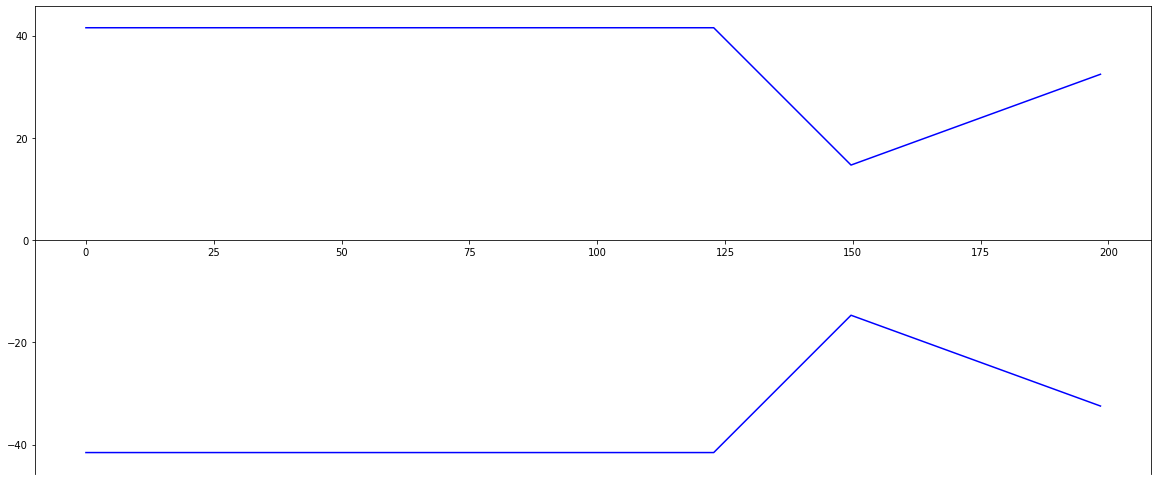

In [8]:
# draw nozzle diagram to give an idea of proportions
%matplotlib inline
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot()
pts=[(0,r_chamber_m*1e3), (L_chamber_m*1e3,r_chamber_m*1e3), (L_chamber_m*1e3+L_converging_m*1e3,r_throat_m*1e3), (L_chamber_m*1e3+L_converging_m*1e3+L_diverging_m*1e3, r_exit_m*1e3)]
xs, ys = zip(*pts)
neg_ys = [-y for y in ys]
ax.set_aspect('equal', 'box')
ax.spines.bottom.set_position('zero')
ax.plot(xs,ys,'b',xs,neg_ys,'b')

## Injector

In [9]:
#input parameters
dP_injector_ox_bar = 5 #pressure drop in ox. inj.
Cd_injector_ox = 0.7 #discharge coefficient in ox inj.
n_injectors_ox = 8

dP_injector_fuel_bar = 5

In [10]:
def injector_area(mdot, Cd, rho, delta_P):
    '''returns total area of injector required to achieve a given mass flow rate,
    given Cd for injector, density of fuel, and pressure drop across injector.
    assumes incompressible fluid flow through a hydraulic orifice (perhaps unreasonable for our oxidiser, GOX...)'''
    return mdot / Cd / np.sqrt(2 * rho * delta_P * 1e5)

In [11]:
# fuel injector
# fuel volume flow rate, used to pick a spray nozzle part
V_dot_fuel_m3ps = m_dot_fuel_kgps / rho_fuel_kgpm3
P_fuel_injector_bar = P_chamber_bar + dP_injector_fuel_bar
print(f'Fuel volume flow rate: {V_dot_fuel_m3ps*1e3:.3f}L/s')


Fuel volume flow rate: 0.494L/s


In [12]:
# oxidiser injector
# lookup oxidiser density at injector inlet using CoolProp
ox = thermo.chemical.Chemical(ox_chem)
ox.calculate(T=T_initial_ox_K, P=P_chamber_bar*constants.bar)
rho_ox_chamber_kgpm3 = ox.rho
ox.calculate(T=T_initial_ox_K, P=P_initial_ox_bar*constants.bar)
rho_ox_tank_kgpm3 = ox.rho
ox.calculate(T=T_initial_ox_K, P=P_std_bar*constants.bar)
rho_ox_std_kgpm3 = ox.rho
print(rho_ox_std_kgpm3)

P_ox_injector_bar = P_chamber_bar + dP_injector_ox_bar

V_dot_injector_ox_m3ps = m_dot_ox_kgps / rho_ox_chamber_kgpm3
V_dot_tank_ox_m3ps = m_dot_ox_kgps/rho_ox_tank_kgpm3
print(f'Oxidiser volume flow rate: {V_dot_injector_ox_m3ps*1e3:.3f}L/s ({V_dot_tank_ox_m3ps*1e3:.3f}L/s exiting tank)')
V_dot_ox_stdft3ps = (m_dot_ox_kgps / rho_ox_std_kgpm3) / constants.foot**3
print((m_dot_ox_kgps / rho_ox_std_kgpm3))
print(f'Oxidiser flow, std. ft^3/s: {V_dot_ox_stdft3ps:.3f}')

print(rho_ox_chamber_kgpm3)

# injector area
A_injector_ox_m2 = injector_area(
    m_dot_ox_kgps,
    Cd_injector_ox,
    rho_ox_chamber_kgpm3,
    dP_injector_ox_bar)
print(f'Total ox. injector area: {A_injector_ox_m2*1e4:.2f}cm^2')
r_injector_ox_m = np.sqrt(A_injector_ox_m2/np.pi/n_injectors_ox)
print(f'Radius of the {n_injectors_ox} ox. injectors: {r_injector_ox_m*1e3:.2f}mm')

1.3094849511594846
Oxidiser volume flow rate: 18.607L/s (2.650L/s exiting tank)
0.5649528808146802
Oxidiser flow, std. ft^3/s: 19.951
39.75828666727488
Total ox. injector area: 1.68cm^2
Radius of the 8 ox. injectors: 2.58mm


## Propellant tanks

In [13]:
V_cylinder_stdft3 = 200
#volume of a K size cylinder, standard cubic feet (SCF)
# (specified by the volume of the gas contained if it were at standard conditions)

m_fuel_kg = m_dot_fuel_kgps * dt_burn_s
print(f'{dt_burn_s}s burn consumes {m_fuel_kg:.3f}kg fuel.')

V_fuel_tank_m3 = V_dot_fuel_m3ps * dt_burn_s
print(f'Volume of fuel consumed: {V_fuel_tank_m3*1e3:.3f}L')

press = thermo.chemical.Chemical(press_chem)
press.calculate(T=T_std_K, P=P_std_bar * constants.bar)
rho_press_std_kgpm3 = press.rho
press.calculate(T=T_initial_fuel_K, P=P_fuel_tank_bar * constants.bar)
rho_press_tank_kgpm3 = press.rho

V_dot_press_stdft3ps = V_dot_fuel_m3ps * rho_press_tank_kgpm3 / rho_press_std_kgpm3 \
    / constants.foot**3
V_press_stdft3 = V_dot_press_stdft3ps * dt_burn_s
print(V_dot_fuel_m3ps * rho_press_tank_kgpm3 / rho_press_std_kgpm3)
print(rho_press_tank_kgpm3)
print(rho_press_std_kgpm3)

print(f'Presurant flow is {V_dot_press_stdft3ps:.3f} SCF/s, total of {V_press_stdft3:.3f} SCF consumed ({V_press_stdft3/V_cylinder_stdft3:.0%} of a {V_cylinder_stdft3}SCF cylinder)')

20s burn consumes 7.998kg fuel.
Volume of fuel consumed: 9.874L
0.019132200769114416
45.792166582796696
1.181632029197839
Presurant flow is 0.676 SCF/s, total of 13.513 SCF consumed (7% of a 200SCF cylinder)


In [14]:
m_ox_kg = m_dot_ox_kgps * dt_burn_s
print(f'{dt_burn_s}s burn consumes {m_ox_kg:.3f}kg oxidizer.')
V_ox_tank_m3 = V_dot_tank_ox_m3ps * dt_burn_s
print(f'(approx.) Oxidiser tank volume: {V_ox_tank_m3*1e3:.3f}L')
V_ox_stdft3=V_dot_ox_stdft3ps*dt_burn_s
print(f'Oxidiser tank SCF (std. ft^3): {V_ox_stdft3:.3f}')
print(f'Requires {V_ox_stdft3/V_cylinder_stdft3:.3f}x {V_cylinder_stdft3}SCF cylinders')

20s burn consumes 14.796kg oxidizer.
(approx.) Oxidiser tank volume: 52.993L
Oxidiser tank SCF (std. ft^3): 399.022
Requires 1.995x 200SCF cylinders


## Valves

In [15]:
# Main fuel valve
# fuel tank --- filter,flow sensor --- main fuel valve --- check valve,engine
dP_fuel_valve_bar = 2 #pressure drop allowable across the main fuel valve

# approx. fuel with gasoline (octane) for now, at fuel tank pressure
fuel = thermo.chemical.Chemical('C8H18', T=T_initial_fuel_K, P=P_fuel_tank_bar*constants.bar)
Cv_main_fuel = fluids.Kv_to_Cv(fluids.size_control_valve_l(rho=rho_fuel_kgpm3,
                                                           Psat=fuel.Psat,
                                                           Pc=fuel.Pc,
                                                           mu=fuel.mu,
                                                           P1=P_fuel_tank_bar*constants.bar,
                                                           P2=(P_fuel_tank_bar-dP_fuel_valve_bar)*constants.bar,
                                                           Q=V_dot_fuel_m3ps))
print(f'Min. Cv for main fuel valve: {Cv_main_fuel:.2f}, Pin={P_fuel_tank_bar}bar, Pout={P_fuel_tank_bar-dP_fuel_valve_bar}bar')

# Main oxidiser valve
# O2 cylinders --- main ox valve --- plumbing --- check valve,engine
frac_dP_ox_valve = 0.5 #pressure drop across main oxidizer
P_ox_valve_bar = P_ox_injector_bar + (P_initial_ox_bar-P_ox_injector_bar) * (1-frac_dP_ox_valve)

ox.calculate(T=T_initial_ox_K, P=P_ox_valve_bar*constants.bar)
mu_ox_Pas = 1e-4 # dynamic viscosity of O2 at standard conditions in 3e-5. Increases with pressure
#if you can find a good source for this lmk
Cv_main_ox = fluids.Kv_to_Cv(fluids.size_control_valve_g(T=T_initial_ox_K,
                                                         MW=ox.MW,
                                                         mu=mu_ox_Pas, # thermo lib won't give a viscosity for ideal gas?
                                                         gamma=ox.isentropic_exponent,
                                                         Z=ox.Z,
                                                         P1=P_initial_ox_bar*constants.bar,
                                                         P2=P_ox_valve_bar*constants.bar,
                                                         Q=V_dot_ox_stdft3ps * (constants.foot**3)))

print(f'Min. Cv for main ox valve: {Cv_main_ox:.2f}, Pin={P_initial_ox_bar}bar, Pout={P_ox_valve_bar}bar')

Min. Cv for main fuel valve: 1.31, Pin=40bar, Pout=38bar
Min. Cv for main ox valve: 0.87, Pin=200bar, Pout=117.5bar


## Piping

In [16]:
#pick pipe material, diameter, length here
pipe_material = fluids.nearest_material_roughness('steel', clean=True) #at least I hope it's clean (;
epsilon = fluids.material_roughness(pipe_material)
print(f'Found in fluids module database: {pipe_material} pipe, surface variation eps={epsilon}m')

Found in fluids module database: Steel pipe, surface variation eps=1.52e-06m


In [21]:
#O2 Piping pressure drop calculation
D_ox_pipe_m = 0.68*constants.inch #Internal Dia. (ID) = OD (3/4") - 2*wall thickness (0.035")
L_ox_pipe_m = 1 #idk
print(f'Calculating pressure drop when ox. plumbing is {D_ox_pipe_m/constants.inch:.3f}" ID, length={L_ox_pipe_m}m')

#calculate pressure drop
v_ox_mps = m_dot_ox_kgps / rho_ox_chamber_kgpm3 / (np.pi / 4 * D_ox_pipe_m**2)
Re = fluids.Reynolds(V=v_ox_mps, D=D_ox_pipe_m, rho = rho_ox_chamber_kgpm3, mu=mu_ox_Pas)
print(f'O2 flow rate: {v_ox_mps:.3f}m/s, Reynolds = {Re:.0f}')
fd = fluids.friction_factor(Re=Re, eD = epsilon/D_ox_pipe_m)
K = fluids.K_from_f(fd=fd, L=L_ox_pipe_m, D=D_ox_pipe_m)
dP_ox_pipe_bar = fluids.dP_from_K(K, rho=rho_ox_chamber_kgpm3, V=v_ox_mps) / constants.bar
print(f'Pressure drop: {dP_ox_pipe_bar:.2f}bar')

Calculating pressure drop when ox. plumbing is 0.680" ID, length=1m
O2 flow rate: 79.416m/s, Reynolds = 545356
Pressure drop: 1.03bar


In [22]:
#Fuel Piping pressure drop calculation
D_fuel_pipe_m = 0.335*constants.inch #inches ID (3/8" OD - 2*0.02" wall)
L_fuel_pipe_m = 1 #id
print(f'Calculating pressure drop when fuel plumbing is {D_fuel_pipe_m/constants.inch:.3f}" ID, length={L_fuel_pipe_m}m')

#calculate pressure drop
v_fuel_mps = m_dot_fuel_kgps / rho_fuel_kgpm3 / (np.pi / 4 * D_fuel_pipe_m**2)
Re = fluids.Reynolds(V=v_fuel_mps, D=D_fuel_pipe_m, rho = rho_fuel_kgpm3, mu=fuel.mu)
print(f'Fuel flow rate: {v_fuel_mps:.3f}m/s, Reynolds = {Re:.0f}')
fd = fluids.friction_factor(Re=Re, eD = epsilon/D_fuel_pipe_m)
K = fluids.K_from_f(fd=fd, L=L_fuel_pipe_m, D=D_fuel_pipe_m)
dP_fuel_pipe_bar = fluids.dP_from_K(K, rho=rho_fuel_kgpm3, V=v_fuel_mps) / constants.bar
print(f'Pressure drop: {dP_fuel_pipe_bar:.2f}bar')

Calculating pressure drop when fuel plumbing is 0.335" ID, length=1m
Fuel flow rate: 8.682m/s, Reynolds = 110492
Pressure drop: 0.67bar
